In [50]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import random_split
# Task: 0
# transformations
transform = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomCrop(28, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# MNIST dataset
dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

# Splitting the dataset into train, validation, and test (60-20-20)
train_size = int(0.6 * len(dataset))
val_size = int(0.2 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_data, val_data, test_data = random_split(dataset, [train_size, val_size, test_size])

In [51]:
print("Training data size:", len(train_data))
print("Validation data size:", len(val_data))
print("Test data size:", len(test_data))


Training data size: 36000
Validation data size: 12000
Test data size: 12000


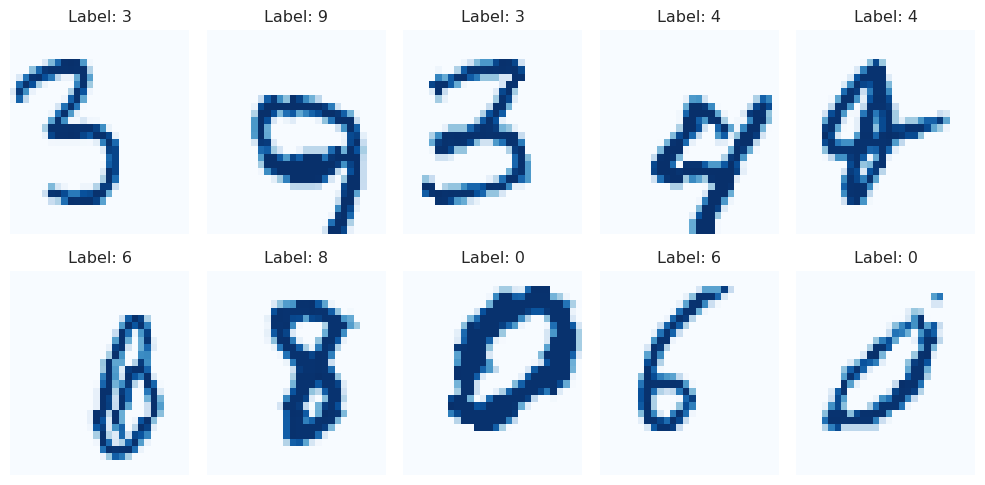

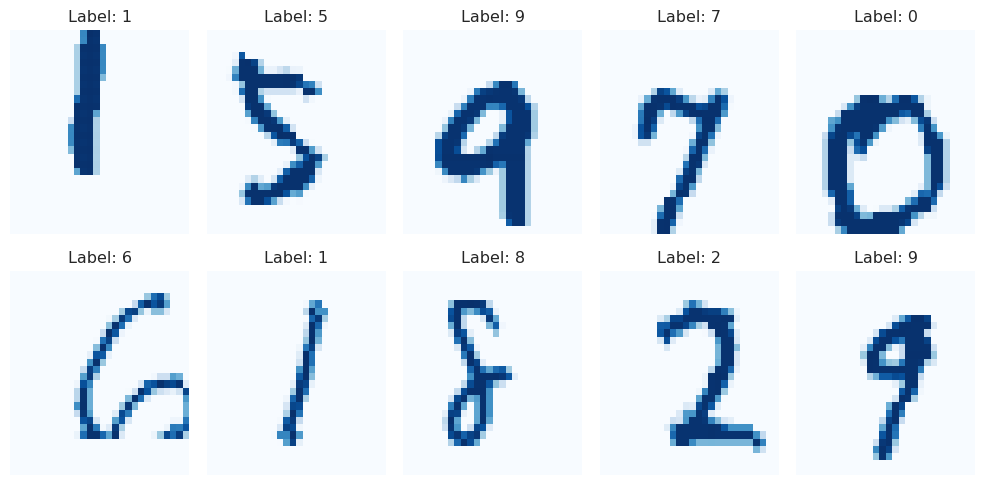

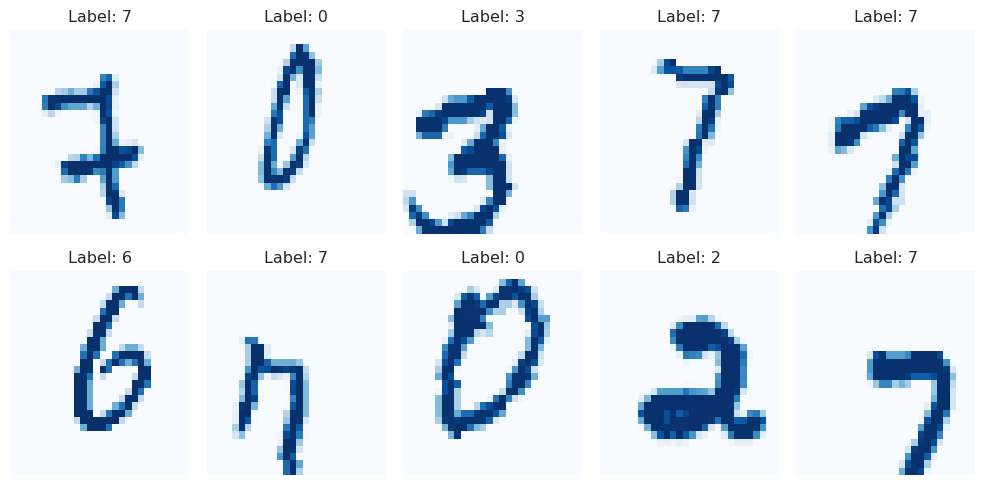

In [52]:
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
# Task-1
# function to plot images
import seaborn as sns

def plot_images(data, num_images=10):
    plt.figure(figsize=(10, 5))
    for i in range(num_images):
        img, label = data[i]
        plt.subplot(2, 5, i + 1)
        sns.heatmap(img.squeeze(), cmap='Blues', cbar=False, xticklabels=False, yticklabels=False)
        plt.title(f'Label: {label}')
    plt.tight_layout()
    plt.show()


# Plotting a few images from each class
plot_images(train_data)
plot_images(val_data)
plot_images(test_data)

# Create data loaders as stated in question
batch_size = 64
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)

In [53]:
# Task-2

import torch.nn as nn

class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 128)  # Input: 28x28 images, Output: 128 features
        self.fc2 = nn.Linear(128, 64)  # Input: 128 features, Output: 64 features
        self.fc3 = nn.Linear(64, 10)  # Input: 64 features, Output: 10 classes

    def forward(self, x):
        x = x.view(-1, 28 * 28)  # Flatten
        x = self.fc1(x)
        x = nn.functional.relu(x)
        x = self.fc2(x)
        x = nn.functional.relu(x)
        x = self.fc3(x)
        return x
#     def forward(self, x):
        # x = x.view(-1, 28 * 28)  # Flatten
        # x = self.fc1(x)
        # x = nn.functional.sigmoid(x)
        # x = self.fc2(x)
        # x = nn.functional.tanh(x)
        # x = self.fc3(x)
        # return x
# Creating an instance of the MLP model
model = MLP()

# Printing the number of trainable parameters
print(f"Number of trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")

Number of trainable parameters: 109386


In [54]:
# Task-3
import torch.optim as optim

#optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# setting the num of epochs to 5
# initializing all the parameters needed for training loop

num_epochs = 5
best_val_accuracy = 0.0

# parameters to print, plot and visualize
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    # Training loop for our model
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    train_loss = running_loss / len(train_loader)
    train_accuracy = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Evaluate the model on the validation set
    model.eval()
    correct = 0
    total = 0
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    val_loss = val_loss / len(val_loader)
    val_accuracy = correct / total
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    # Save the model if it has the best validation accuracy
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        best_model_state_dict = model.state_dict()

    # Log the accuracy and loss
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {train_loss}, Val Loss: {val_loss}, Train Acc: {train_accuracy}, Val Acc: {val_accuracy}")

# Save the best model
if best_model_state_dict is not None:
    torch.save(best_model_state_dict, 'best_model.pth')

Epoch 1/5, Loss: 0.8115221566882904, Val Loss: 0.43172285309497344, Train Acc: 0.7391388888888889, Val Acc: 0.8683333333333333
Epoch 2/5, Loss: 0.37524498170688353, Val Loss: 0.3403417958699642, Train Acc: 0.8856388888888889, Val Acc: 0.8956666666666667
Epoch 3/5, Loss: 0.30637476693832216, Val Loss: 0.27746317757571, Train Acc: 0.9056666666666666, Val Acc: 0.9145833333333333
Epoch 4/5, Loss: 0.2690544455158351, Val Loss: 0.2506233395493411, Train Acc: 0.9171666666666667, Val Acc: 0.9210833333333334
Epoch 5/5, Loss: 0.24426180097815411, Val Loss: 0.2379980849775862, Train Acc: 0.9230277777777778, Val Acc: 0.9298333333333333


In [55]:
test_correct = 0
test_total = 0

# Evaluate the model on the test set
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

test_accuracy = test_correct / test_total

# Log the test accuracy
print(f"Test Accuracy: {test_accuracy}")


Test Accuracy: 0.9331666666666667


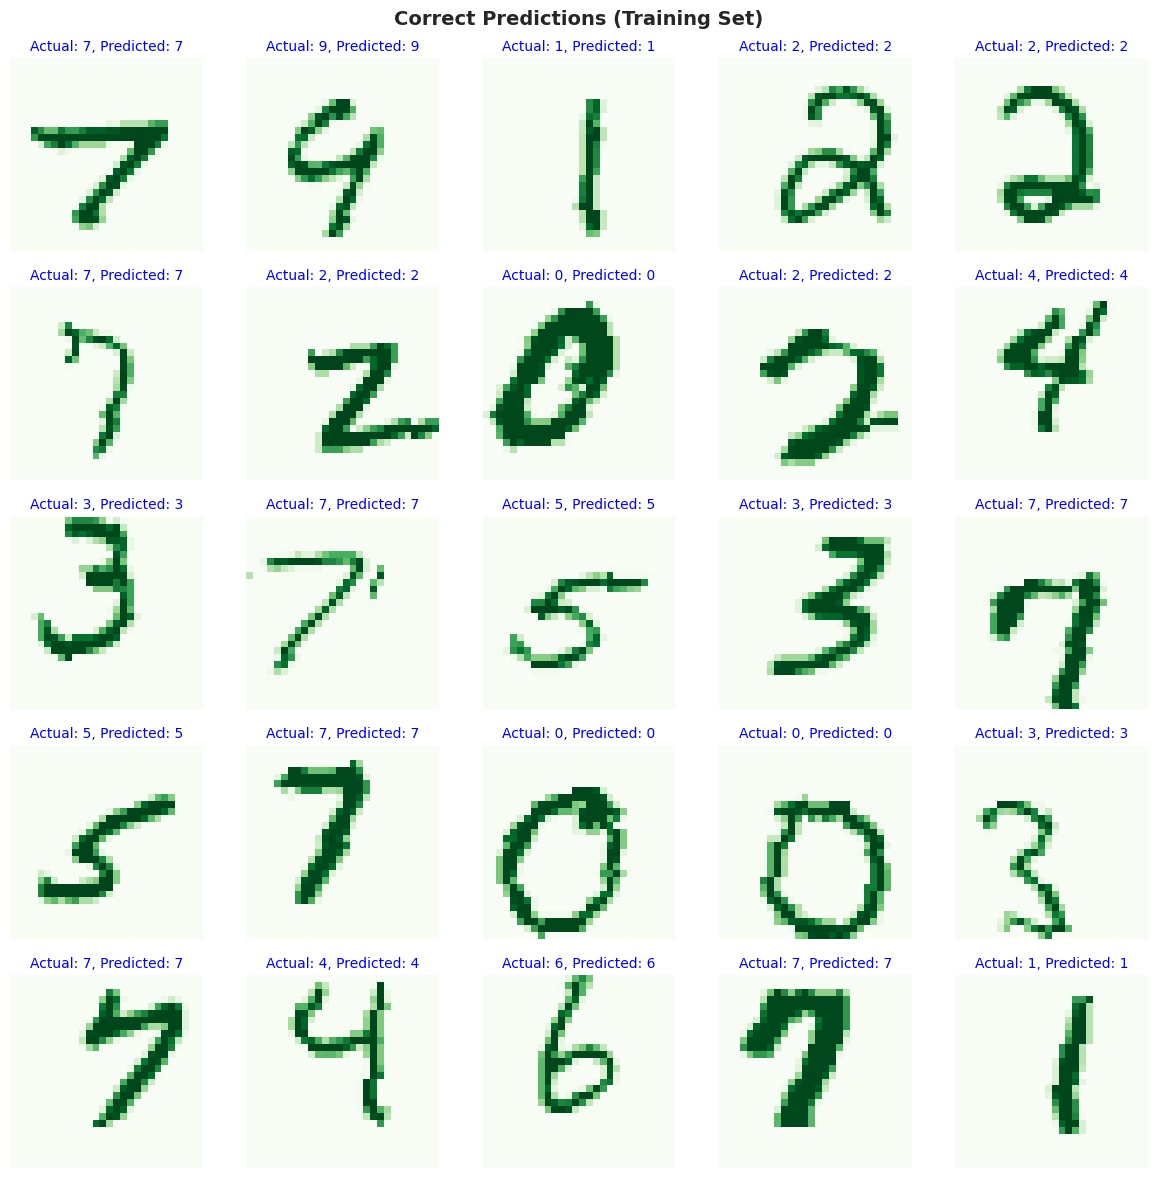

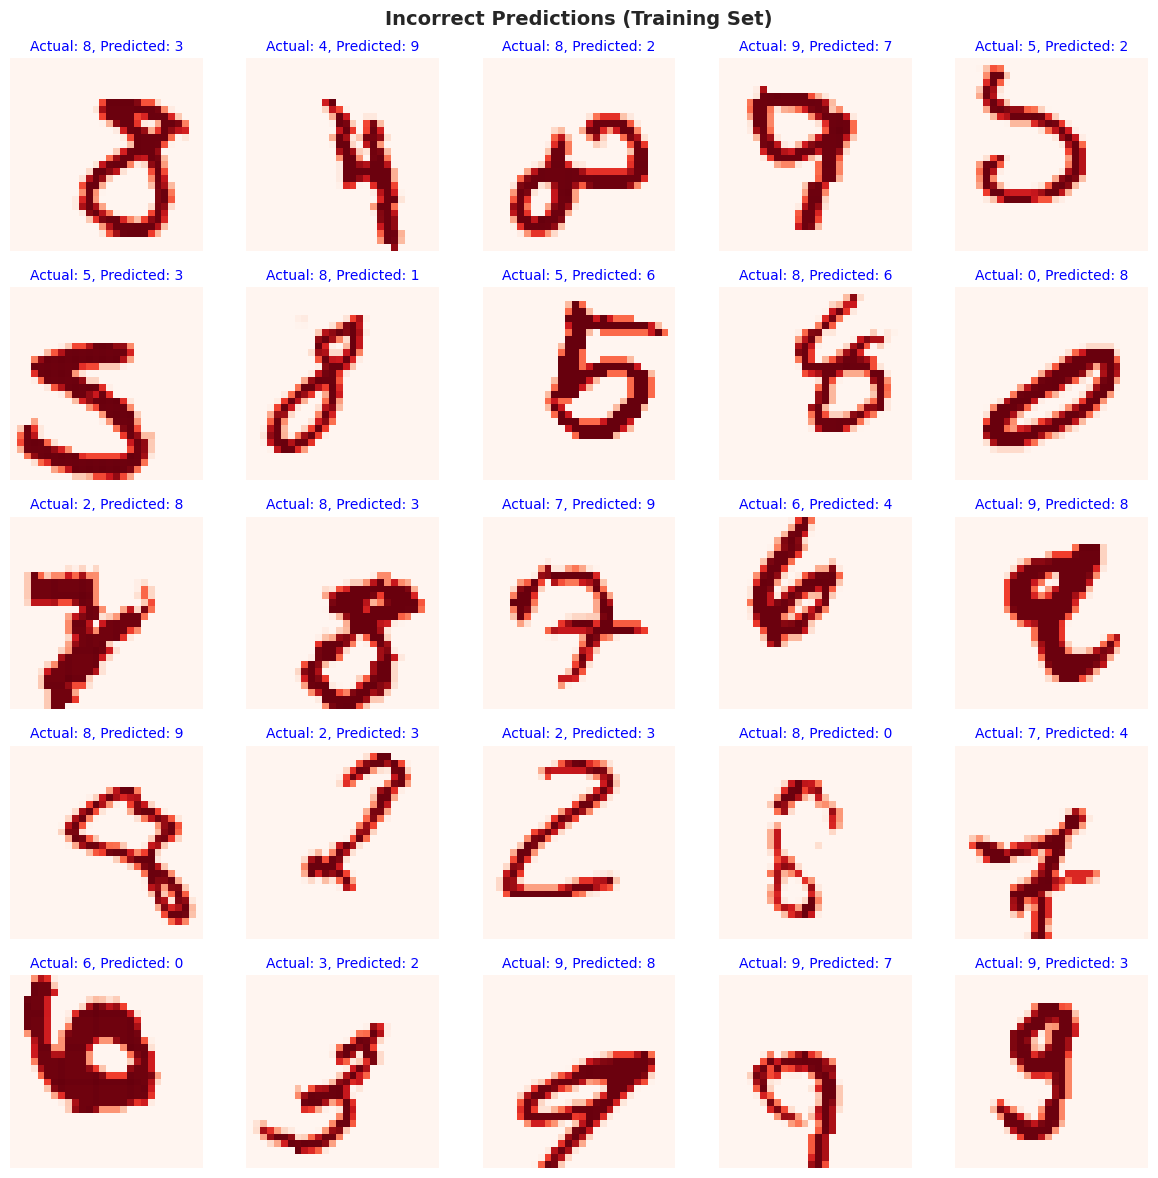

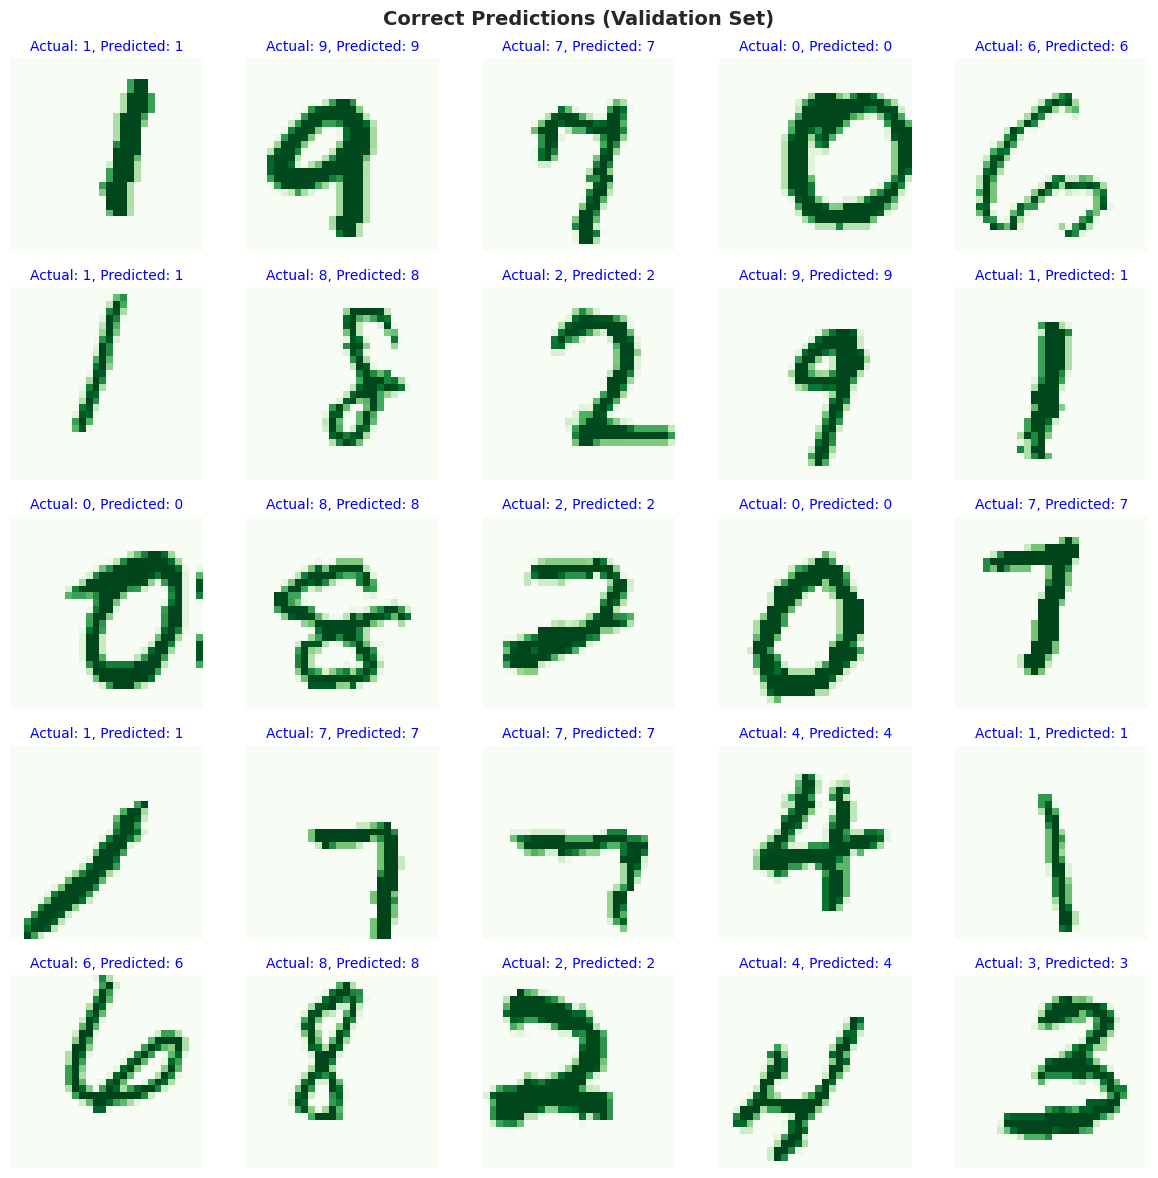

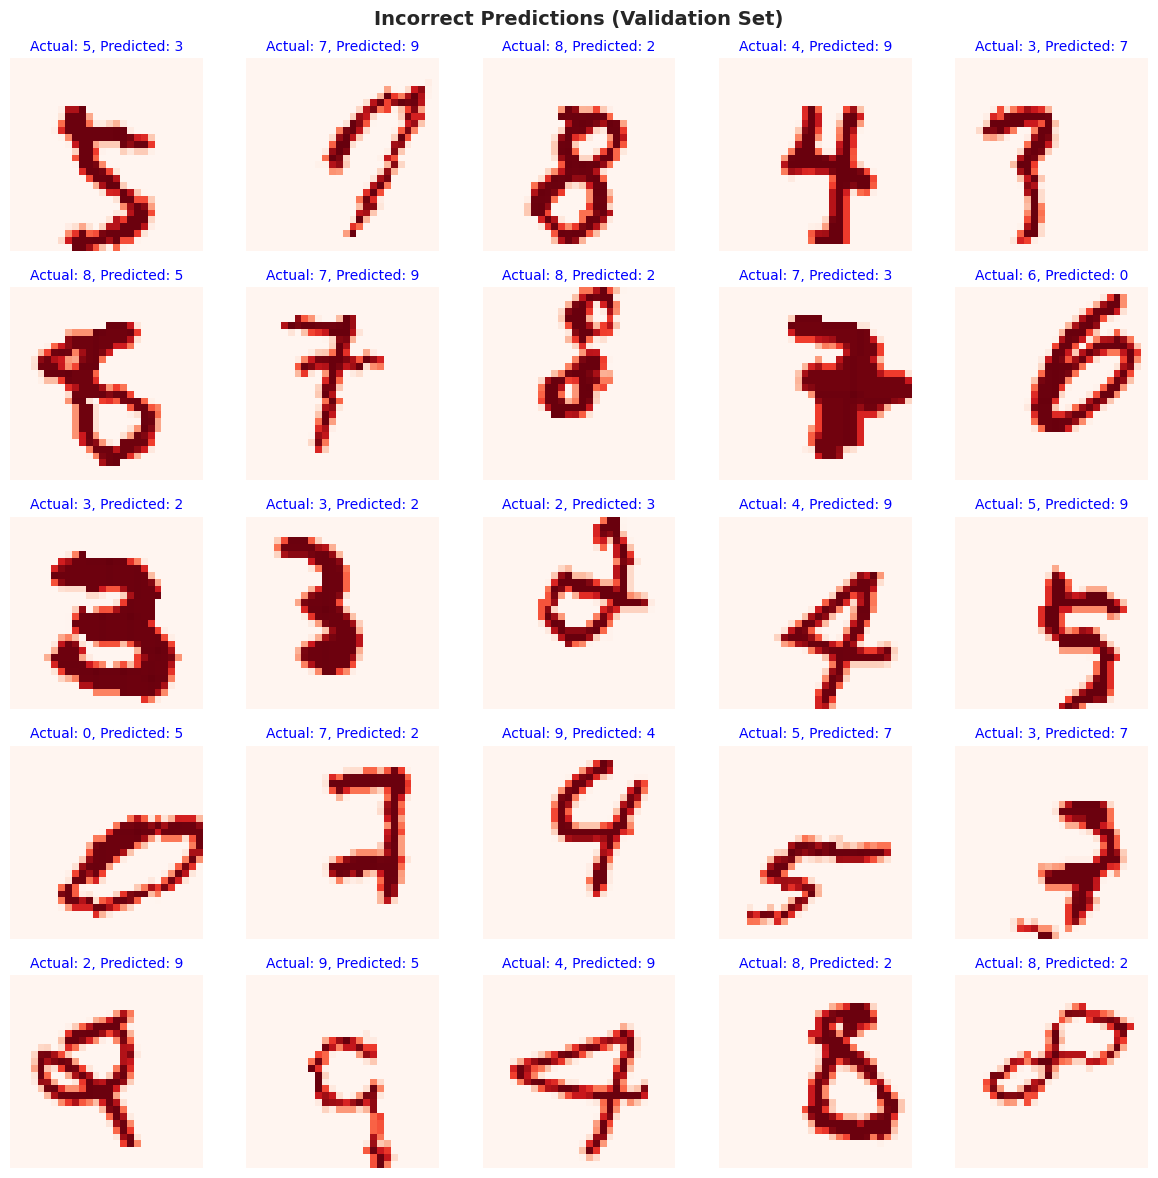

In [56]:
import matplotlib.pyplot as plt
import numpy as np

# Task-4
# plt_predictions function

def plot_predictions(model, data_loader):
    model.eval()
    correct_imgs = [] # list to store correct images

    correct_labels = [] # list to store correct labels
    correct_preds = []  # list to store predicted labels for correct predictions
    incorrect_imgs = [] # list to store incorrectly predicted images
    incorrect_labels = [] # list to store correct labels for incorrectly predicted images
    incorrect_preds = []  # list to store predicted labels for incorrect predictions

    with torch.no_grad():
        for images, labels in data_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            for i in range(len(labels)):
                if predicted[i] == labels[i]:
                    correct_imgs.append(images[i])
                    correct_labels.append(labels[i])
                    correct_preds.append(predicted[i])
                else:
                    incorrect_imgs.append(images[i])
                    incorrect_labels.append(labels[i])
                    incorrect_preds.append(predicted[i])
    correct_imgs = torch.stack(correct_imgs) # creating stack of images to visualize the correct and incorrect labels
    incorrect_imgs = torch.stack(incorrect_imgs)
    return correct_imgs, correct_labels, correct_preds, incorrect_imgs, incorrect_labels, incorrect_preds



# grid plotting function
def plot_predictions_grid(images, actual_labels, predicted_labels, title):
    num_images = len(images)
    rows = int(np.sqrt(num_images))
    cols = int(np.ceil(num_images / rows))
    plt.figure(figsize=(12, 12))
    for i in range(num_images):
        plt.subplot(rows, cols, i + 1)
        cmap = 'Greens' if actual_labels[i] == predicted_labels[i] else 'Reds'
        sns.heatmap(images[i].cpu().numpy().squeeze(), cmap=cmap, cbar=False, xticklabels=False, yticklabels=False, square=True)
        plt.title(f'Actual: {actual_labels[i]}, Predicted: {predicted_labels[i]}', fontsize=10, color='blue')
    plt.suptitle(title, fontsize=14, weight='bold')
    plt.tight_layout()
    plt.show()


# Getting correct and incorrect predictions along with predicted labels
correct_imgs_train, correct_labels_train, correct_preds_train, incorrect_imgs_train, incorrect_labels_train, incorrect_preds_train = plot_predictions(model, train_loader)
correct_imgs_val, correct_labels_val, correct_preds_val, incorrect_imgs_val, incorrect_labels_val, incorrect_preds_val = plot_predictions(model, val_loader)

# Plotting correct and incorrect predictions with actual and predicted labels
plot_predictions_grid(correct_imgs_train[:25], correct_labels_train[:25], correct_preds_train[:25], 'Correct Predictions (Training Set)')
plot_predictions_grid(incorrect_imgs_train[:25], incorrect_labels_train[:25], incorrect_preds_train[:25], 'Incorrect Predictions (Training Set)')
plot_predictions_grid(correct_imgs_val[:25], correct_labels_val[:25], correct_preds_val[:25], 'Correct Predictions (Validation Set)')
plot_predictions_grid(incorrect_imgs_val[:25], incorrect_labels_val[:25], incorrect_preds_val[:25], 'Incorrect Predictions (Validation Set)')


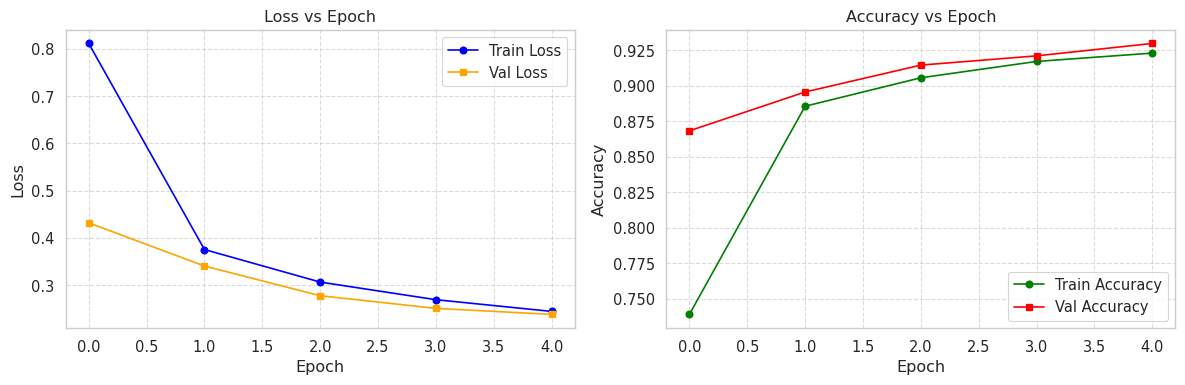

In [57]:
import seaborn as sns
# Seaborn style and font
sns.set_style("whitegrid")
sns.set_context("paper", font_scale=1.2)

# Plotting loss graphs for train and val
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss', marker='o', color='blue')
plt.plot(val_losses, label='Val Loss', marker='s', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epoch')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)

# Plotting accuracy graphs for train and val
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy', marker='o', color='green')
plt.plot(val_accuracies, label='Val Accuracy', marker='s', color='red')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epoch')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

In [58]:
from sklearn.metrics import classification_report



def evaluate_model(model, data_loader):
    model.eval()
    all_labels = []
    all_predictions = []
    with torch.no_grad():
        for images, labels in data_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            all_labels.extend(labels.numpy())
            all_predictions.extend(predicted.numpy())
    return all_labels, all_predictions



# classification report for the training data
train_labels, train_predictions = evaluate_model(model, train_loader)
print("Classification Report for Training Data:")
print(classification_report(train_labels, train_predictions))

# classification report for the validation data
val_labels, val_predictions = evaluate_model(model, val_loader)
print("\nClassification Report for Validation Data:")
print(classification_report(val_labels, val_predictions))


Classification Report for Training Data:
              precision    recall  f1-score   support

           0       0.95      0.96      0.96      3564
           1       0.98      0.96      0.97      4000
           2       0.86      0.95      0.90      3594
           3       0.93      0.89      0.91      3724
           4       0.94      0.93      0.93      3514
           5       0.94      0.91      0.92      3255
           6       0.95      0.96      0.96      3561
           7       0.92      0.95      0.93      3729
           8       0.92      0.89      0.90      3524
           9       0.91      0.89      0.90      3535

    accuracy                           0.93     36000
   macro avg       0.93      0.93      0.93     36000
weighted avg       0.93      0.93      0.93     36000


Classification Report for Validation Data:
              precision    recall  f1-score   support

           0       0.96      0.97      0.97      1177
           1       0.99      0.96      0.97    

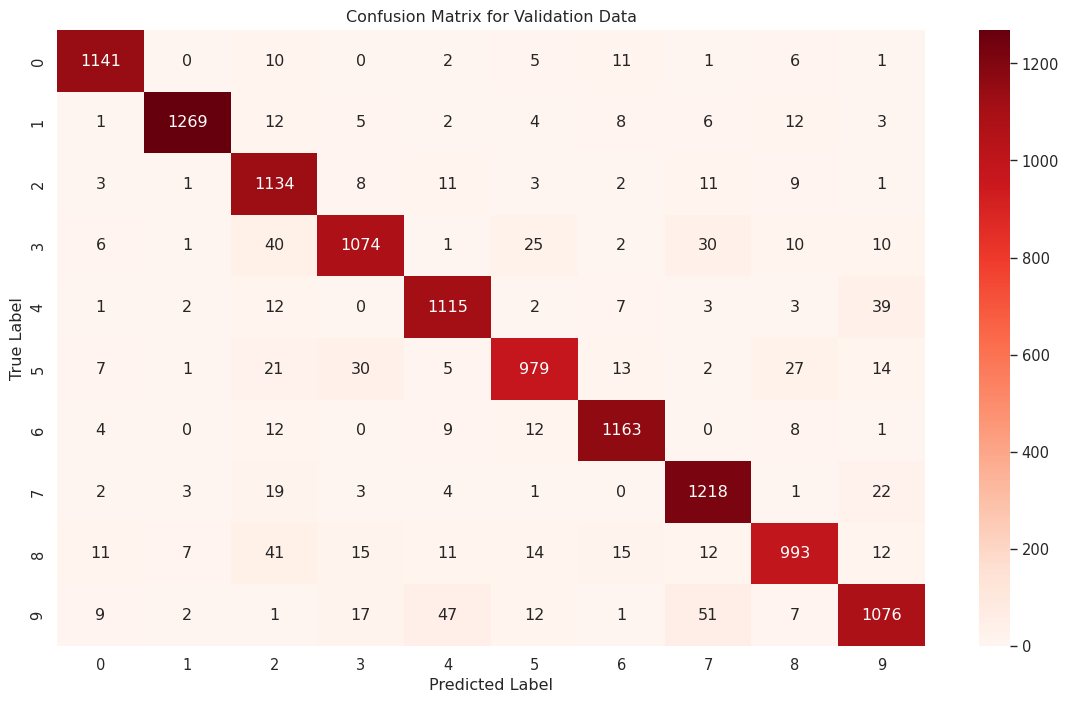

In [59]:
from sklearn.metrics import confusion_matrix
# confusion matrix
val_cm = confusion_matrix(val_labels, val_predictions)

# Plotting the confusion matrix for validation data
# this can also help us identifying the pattern where our prediction is going wrong

plt.figure(figsize=(14, 8))
sns.heatmap(val_cm, annot=True, fmt="d", cmap="Reds") # using the seaborn library to show the proper heatmap visualization
plt.title("Confusion Matrix for Validation Data")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()